# 6 School data

Taken from [arViz](https://arviz-devs.github.io/arviz/getting_started/CreatingInferenceData.html#from-numpyro) documentation.

In [1]:
import numpyro
import numpyro.distributions as dist

import numpy as np

from jax.random import PRNGKey
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

import arviz as az

numpyro.set_host_device_count(4)

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}


def model(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    # use non-centered reparameterization
    theta = numpyro.sample(
        "theta",
        dist.TransformedDistribution(
            dist.Normal(np.zeros(J), 1), AffineTransform(mu, tau)
        ),
    )
    numpyro.sample("y", dist.Normal(theta, sigma), obs=y)


kernel = NUTS(model)
mcmc = MCMC(
    kernel, num_warmup=1000, num_samples=500, num_chains=4, chain_method="parallel"
)
mcmc.run(PRNGKey(0), **eight_school_data, extra_fields=["num_steps", "energy"])
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    PRNGKey(1), eight_school_data["J"], eight_school_data["sigma"]
)
prior = Predictive(model, num_samples=500)(
    PRNGKey(2), eight_school_data["J"], eight_school_data["sigma"]
)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [2]:

numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"school": np.arange(eight_school_data["J"])},
    dims={"theta": ["school"]},
)
numpyro_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

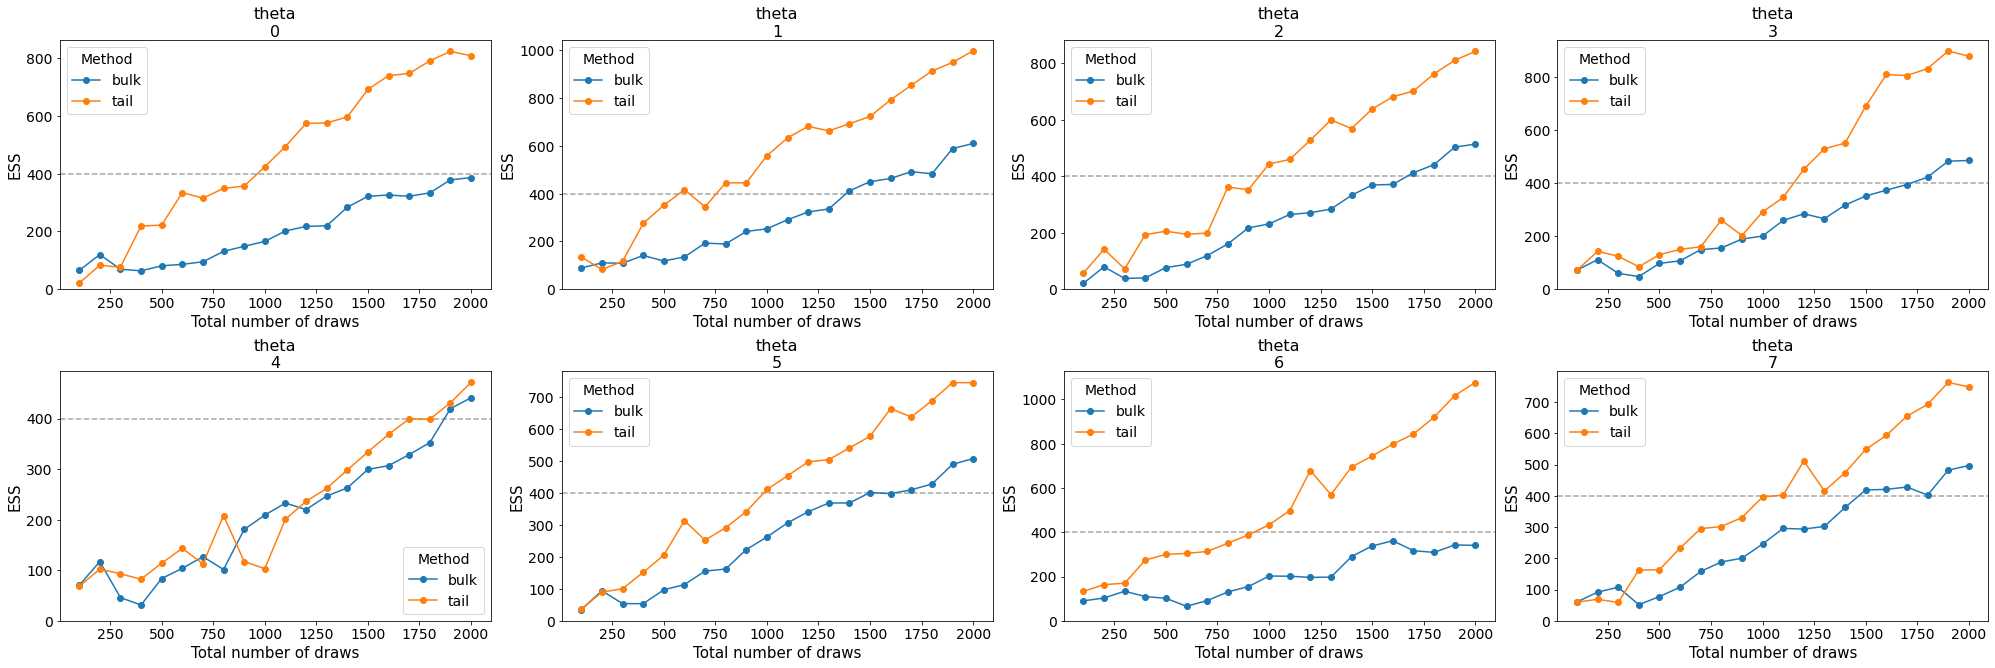

In [3]:
az.plot_ess(numpyro_data, var_names=["theta"], kind="evolution");

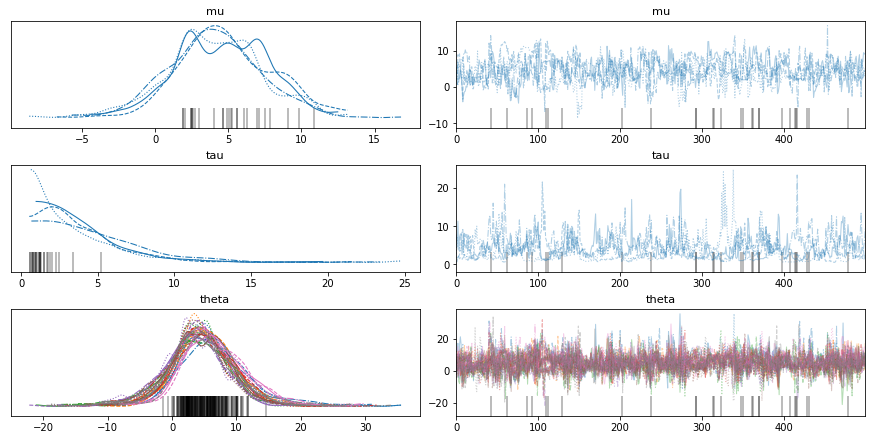

In [4]:
az.plot_trace(numpyro_data);

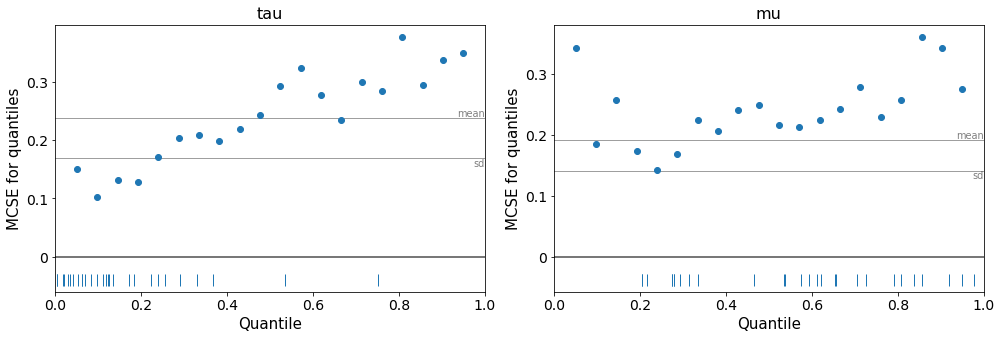

In [7]:
az.plot_mcse(numpyro_data, var_names=["tau", "mu"], rug=True, extra_methods=True);